In [13]:
from os import getcwd,listdir,chdir
home = getcwd()

import micom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.diversity import alpha,beta_diversity
from scipy.stats import zscore,pearsonr,ttest_ind

sns.set(context= 'talk',style='ticks',font_scale=1,rc ={'axes.spines.right': False,'axes.spines.top': False},palette='colorblind')

In [2]:
ncbi_tax=pd.read_csv('../data/David_et_al_ncbi-taxonomy.tsv',sep='\t',index_col=0,skiprows=[1])
ncbi_tax

,Taxon,Confidence
Feature ID,,
26367b8df231270b625deda65c8894a9,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.995880
ce65f7bd4fe6af32b8db5493cb9fb48c,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.993213
e872b0cddb362e57d8e81db8bff0b0c3,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.972759
0e1b844e10f1bfc5c63e1dca7c9a615c,k__Bacteria; p__Actinobacteria; c__Actinobacte...,0.999975
52edfa351c4e02177431fa4a5fd6f0e5,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.993686
...,...,...
c5c8f0317b82d00cc17bffe67e179f46,k__Bacteria,0.993685
332ba5e42f75e3eaf7036302bf8f920b,k__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.994448
7561beb424e2b8f62dbc5b280bbc3879,k__Bacteria,0.971711


In [3]:
def taxmap(taxonomy,level='phylum'):
    #Green genes format
    lmap = {'genus':'g','family':'f','order':'o','phylum':'p'}
    l=lmap[level]
    gg_map = {}
    for i in taxonomy.index:
        t = taxonomy.loc[i,'Taxon']
        if l+'__' in t:
            for tx in t.split(';'):
                if l+'__' in tx:
                    t=tx.split('__')[1]
                    break
            if t != '':
                if '[' in t:
                    t =t[1:-1]
                gg_map[i]=t
            else:
                gg_map[i]='Unclassified'
        else:
            gg_map[i]='Unclassified'
    return gg_map
    

phylum=taxmap(ncbi_tax,level='phylum')
family=taxmap(ncbi_tax,level='family')
genus=taxmap(ncbi_tax,level='genus')

tax={}
for key in phylum.keys():
    tax[key]=tuple([phylum[key],family[key],genus[key]])
tax

{'26367b8df231270b625deda65c8894a9': ('Bacteroidetes',
  'Bacteroidales',
  'Phocaeicola'),
 'ce65f7bd4fe6af32b8db5493cb9fb48c': ('Firmicutes',
  'Ruminococcaceae',
  'Unclassified'),
 'e872b0cddb362e57d8e81db8bff0b0c3': ('Firmicutes',
  'Ruminococcaceae',
  'Faecalibacterium'),
 '0e1b844e10f1bfc5c63e1dca7c9a615c': ('Actinobacteria',
  'Bifidobacteriaceae',
  'Bifidobacterium'),
 '52edfa351c4e02177431fa4a5fd6f0e5': ('Bacteroidetes',
  'Bacteroidales',
  'Phocaeicola'),
 '99e180a2f5e25a226563e96f40bdff2b': ('Bacteroidetes',
  'Bacteroidaceae',
  'Bacteroides'),
 'cca5c6c27056ded09811bfdf442e788b': ('Bacteroidetes',
  'Bacteroidales',
  'Phocaeicola'),
 '49105a9e0ac7dc25e7235e7e713c2227': ('Firmicutes',
  'Erysipelotrichaceae',
  'Erysipelatoclostridium'),
 '493dec0244180c758e1b3bd2f1ea7c4e': ('Firmicutes',
  'Lachnospiraceae',
  'Unclassified'),
 'b3694ea4952d8198c51840e0f6b2b6df': ('Firmicutes',
  'Lachnospiraceae',
  'Blautia'),
 'c298ce8746266ffe04bb3f477e785725': ('Bacteroidetes',
 

In [4]:
meta=pd.read_csv('../data/David_et_al_RunMeta.csv')
meta=meta[meta['ANONYMIZED_NAME'].str.contains('Stool')]
meta['patient']=[x.split()[0] for x in meta['Description']]
meta['sample']=[int(x[5:]) for x in meta['ANONYMIZED_NAME']]
meta=meta.sort_values(by=['patient','sample'])
meta

,Unnamed: 0,AGE,AGE_UNIT,ALTITUDE,ANONYMIZED_NAME,ASSIGNED_FROM_GEO,BODY_HABITAT,BODY_MASS_INDEX,BODY_PRODUCT,BODY_SITE,...,SEQUENCING_METH,SEX,STUDY_CENTER,STUDY_ID,TARGET_GENE,TARGET_SUBFRAGMENT,TAXON_ID,TITLE,patient,sample
286,Stool1.1260006,26,years,0,Stool1,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorA,1
397,Stool2.1259766,26,years,0,Stool2,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorA,2
494,Stool3.1260328,26,years,0,Stool3,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorA,3
605,Stool4.1260013,26,years,0,Stool4,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorA,4
716,Stool5.1259738,26,years,0,Stool5,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorA,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,Stool544.1259616,36,years,0,Stool544,n,UBERON:feces,21.5,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorB,544
767,Stool545.1259817,36,years,0,Stool545,n,UBERON:feces,21.5,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorB,545
768,Stool546.1259907,36,years,0,Stool546,n,UBERON:feces,21.5,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorB,546
769,Stool547.1259931,36,years,0,Stool547,n,UBERON:feces,21.5,UBERON:feces,UBERON:feces,...,sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series,DonorB,547


In [5]:
def normalize_poscounts(counts):
    """Normalize count matrix. Taxa on columns, samples on rows.
    Uses the poscounts method, meaning that zero sample counts are substituted
    with the n-th root of the geometric mean in all non-zero samples.
    Parameters
    ----------
    counts : pandas.DataFrame
        The count matrix to be normalized. Contains variables as columns and
        samples as rows.
    Returns
    -------
    pandas.DataFrame
        A new data frame with normalized samples such that each sample has
        a median log fold change of zero from the reference sample (mean
        of all samples).
    """
    geo_means = counts.apply(lambda x: np.log(x[x > 0]).sum() / len(x), axis=0)

    if not all(np.isfinite(geo_means)):
        raise ValueError("At least one taxa is absent in all samples!")

    print("Normalizing by geometric means.")
    size_factors = counts.apply(lambda x: sample_factors(x, geo_means), axis=1)
    norm_counts = counts.divide(size_factors, axis=0)
    print("Size factor 95%% confidence interval: [%g, %g]" %
                tuple(np.percentile(size_factors.dropna(), [2.5, 97.5])))
    return norm_counts, size_factors


def rarefy_counts(counts, depth=10000):
    """Normalize a count matrix by rarefaction (subsampling).
    Parameters
    ----------
    counts : pandas.DataFrame
        The count matrix to be normalized. Contains variables as columns and
        samples as rows.
    Returns
    -------
    pandas.DataFrame
        A new data frame with normalized samples such that each sample has
        a depth of `depth` (sum of variables equals depth).
    """
    print("Subsampling %dx%d count matrix to a depth of %d." %
                (counts.shape[0], counts.shape[1], depth))
    bad = counts.sum(1) < depth
    print("Removing %d samples due to low depth." % bad.sum())
    counts = counts[~bad]
    rare = counts.apply(lambda x: pd.Series(
        subsample_counts(x.astype("int"), depth), index=counts.columns),
        axis=1)
    return rare


def filter_counts(counts, mean=5, presence=0.05):
    """Filter a count matrix for rare taxa.
    Parameters
    ----------
    counts : pandas.DataFrame
        The count matrix to be filtered. Contains variables as columns and
        samples as rows.
    mean : positive float
        The smallest mean count a taxon has to have across all samples.
    presence : float in (0, 1)
        The taxon hast to be present in at least this fraction of samples.
    Returns
    -------
    pandas.DataFrame
        Filtered count matrix with the same rows as `counts` but possibly less
        columns (taxa).
    """
    pre = (counts > 0).mean()
    means = counts.mean()
    good = (pre > presence) & (means > mean)
    print("Filtering count matrix: %d passed, %d removed." %
                (good.sum(), counts.shape[1] - good.sum()))
    return counts.loc[:, good]


In [6]:
asvs=pd.read_csv('../data/David_et_al_asv_counts.tsv',sep='\t',index_col=0,skiprows=[1])
filt_asvs=filter_counts(asvs)

multi=[]
drop=[]
for i in filt_asvs.index:
    if i in list(meta['ANONYMIZED_NAME']):
        multi.append(tuple(meta[meta['ANONYMIZED_NAME']==i][['patient','COLLECTION_DAY']].values[0]))
    else:
        drop.append(i)
filt_asvs=filt_asvs.drop(drop)
filt_asvs.index=pd.MultiIndex.from_tuples(multi)
filt_asvs=filt_asvs.sort_index()
filt_asvs

Filtering count matrix: 301 passed, 1585 removed.


26367b8df231270b625deda65c8894a9  \
DonorA 0                               16982   
       2                               23115   
       3                                   0   
       4                               31986   
       5                               40607   
...                                      ...   
DonorB 231                              6584   
       232                              9796   
       241                             19782   
       242                             10976   
       318                              3986   

            ce65f7bd4fe6af32b8db5493cb9fb48c  \
DonorA 0                               24211   
       2                               26376   
       3                                   3   
       4                               31747   
       5                               46797   
...                                      ...   
DonorB 231                             15048   
       232                                 0   
       241                                 0   
       242                                 0   
       318                              8775   

            e872b0cddb362e57d8e81db8bff0b0c3  \
DonorA 0                                4156   
       2                                8696   
       3                                   0   
       4                               13673   
       5                               18283   
...                                      ...   
DonorB 231                              1894   
       232                             18296   
       241                             35490   
       242                             10916   
       318                             17945   

            0e1b844e10f1bfc5c63e1dca7c9a615c  \
DonorA 0                                4707   
       2                               13743   
       3                                   0   
       4                               18243   
       5                               26179   
...                                      ...   
DonorB 231                             10316   
       232                                 0   
       241                                 0   
       242                                 0   
       318                              5697   

            52edfa351c4e02177431fa4a5fd6f0e5  \
DonorA 0                                   0   
       2                                   0   
       3                                   0   
       4                                   0   
       5                                   0   
...                                      ...   
DonorB 231                                 0   
       232                             30970   
       241                             14929   
       242                              7698   
       318                              6109   

            99e180a2f5e25a226563e96f40bdff2b  \
DonorA 0                                6710   
       2                                8305   
       3                                   0   
       4                                7788   
       5                                9083   
...                                      ...   
DonorB 231                              5279   
       232                              8779   
       241                              7420   
       242                              3429   
       318                              6049   

            cca5c6c27056ded09811bfdf442e788b  \
DonorA 0                                3548   
       2                                5937   
       3                                   0   
       4                                4072   
       5                               13178   
...                                      ...   
DonorB 231                              2941   
       232                                 0   
       241                                 0   
       242                                 0   
       318            

In [7]:
depth=10000
from skbio.stats import composition, subsample_counts
mapped=filt_asvs.copy()
mapped.columns=mapped.columns.map(tax)
mapped=mapped.groupby(level=[0,1,2],axis=1).sum()
mapped= rarefy_counts(mapped,depth=depth)
mapped=mapped.groupby(level=[0,1]).mean()
relabund=mapped/depth
#relabund=relabund[relabund.groupby(level=2,axis=1).sum()['Unclassified']<0.05]
#relabund=relabund[relgenus['Unclassified']<=0.2]
#cols=relabund.columns.drop('Unclassified',level=0)
#relabund=relabund[cols]
cols=relabund.columns.drop('Unclassified',level=1)
relabund=relabund[cols]
relabund

Subsampling 417x105 count matrix to a depth of 10000.
Removing 17 samples due to low depth.


Actinobacteria                                                 \
           Actinomycetaceae                Atopobiaceae Bifidobacteriaceae   
                   Schaalia Unclassified Lancefieldella    Bifidobacterium   
DonorA 0             0.0000       0.0002            0.0             0.0390   
       2             0.0002       0.0000            0.0             0.0772   
       4             0.0002       0.0000            0.0             0.0960   
       5             0.0002       0.0000            0.0             0.0896   
       6             0.0000       0.0000            0.0             0.0214   
...                     ...          ...            ...                ...   
DonorB 231           0.0002       0.0000            0.0             0.1032   
       232           0.0000       0.0000            0.0             0.0004   
       241           0.0000       0.0000            0.0             0.0001   
       242           0.0000       0.0000            0.0             0.0002   
       318           0.0000       0.0000            0.0             0.0594   

                                                                        \
           Coriobacteriaceae Eggerthellaceae                             
                 Collinsella   Adlercreutzia Eggerthella Gordonibacter   
DonorA 0              0.0001             0.0      0.0011        0.0000   
       2              0.0003             0.0      0.0008        0.0000   
       4              0.0000             0.0      0.0003        0.0000   
       5              0.0004             0.0      0.0011        0.0001   
       6              0.0002             0.0      0.0001        0.0000   
...                      ...             ...         ...           ...   
DonorB 231            0.0010             0.0      0.0012        0.0000   
       232            0.0000             0.0      0.0025        0.0003   
       241            0.0000             0.0      0.0007        0.0003   
       242            0.0000             0.0      0.0011        0.0003   
       318            0.0000             0.0      0.0033        0.0004   

            Bacteroidetes                ... Proteobacteria               \
           Bacteroidaceae Bacteroidales  ... Comamonadaceae                
              Bacteroides   Phocaeicola  ...      Pelomonas Unclassified   
DonorA 0           0.1181        0.1654  ...         0.0000       0.0000   
       2           0.1020        0.1638  ...         0.0000       0.0000   
       4           0.0957        0.1912  ...         0.0000       0.0000   
       5           0.0722        0.1785  ...         0.0000       0.0001   
       6           0.1491        0.3221  ...         0.0004       0.0004   
...                   ...           ...  ...            ...          ...   
DonorB 231         0.0872        0.0984  ...         0.0000       0.0000   
       232         0.1482        0.3574  ...         0.0008       0.0003   
       241         0.1974        0.2579  ...         0.0000       0.0000   
       242         0.2682        0.2064  ...         0.0001       0.0004   
       318         0.1302        0.1028  ...         0.0007       0.0005   

                                                                 \
           Desulfovibrionaceae Enterobacteriaceae Moraxellaceae   
                  Unclassified       Unclassified Acinetobacter   
DonorA 0                0.0019             0.0007        0.0000   
       2                0.0002             0.0000        0.0000   
       4                0.0002             0.0000        0.0000   
       5                0.0009             0.0000        0.0000   
       6                0.0007             0.0000        0.0001   
...                        ...                ...           ...   
DonorB 231              0.0014             0.0000        0.0000   
       232              0.0000             0.0000        0.0001   
       241              0.0000             0.0000        0.0002   
       242    

In [8]:
def reduce_group(df):
    new = df.iloc[0, :]
    new["file"] = "|".join(df.id.apply(lambda id: f"{id}.xml"))
    return new

'''
data = unprocessed dataframe
'''
def merge(data,agora,level='genus'):
    keep = ["samples","kingdom","phylum","class","order","family","genus","oxygenstat","metabolism","gram","mtype","genes","file","reads","relative"]
    group = data.groupby(["id", level]).sum().reset_index()
    merge = pd.merge(group, agora, on=level, suffixes=["_x", ""])
    merge['samples'] = merge['id_x']
    merge = merge[keep]
    return merge

'''
data   = dataframe after agora merge
prefix = sample prefix
'''
def invade(data, prefix, rel,level='genus'):
    genus_df = pd.DataFrame(columns = data.columns)
    
    for index,sample in data.groupby(by='samples'):
        reads = ((sample['reads'].sum() / (1.0 - rel) - sample['reads'].sum()))
        cdiff['reads'] = reads.round()
        cdiff['samples'] = str(index)
        cdiff['relative'] = reads / (sample['reads'].sum() + reads)
        sample = sample.append(cdiff)
        genus_df = genus_df.append(sample)    
    genus_df['samples'] = genus_df['samples'].astype(str)
    genus_df = genus_df.reset_index(drop=True)
    return genus_df

In [9]:
keep = ["samples","kingdom","phylum","class","order","family","genus","oxygenstat","metabolism","gram","mtype","genes","file","reads","relative"]
agora=pd.read_csv('../data/agora103_genus.csv')

cdiff = agora[agora.genus=='Clostridioides']
for column in cdiff.columns:
    if column not in keep:
        cdiff = cdiff.drop(column, axis=1).copy()
agora = agora[agora.genus!='Clostridioides']
agora

,organism,seedid,oxygenstat,metabolism,gram,mtype,genes,reactions,metabolites,draftcreator,...,phylum,class,order,family,genus,species,file,kbaseid,id,summary_rank
0,Abiotrophia defectiva ATCC 49176,Abiotrophia defectiva ATCC 49176 (592010.4),Facultative anaerobe,"Saccharolytic, fermentative or respiratory",Positive,Pathogen,631.0,2428.0,1250.0,Eugen Bauer,...,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia defectiva,Abiotrophia.json,NaN,Abiotrophia,genus
1,Clostridium sticklandii DSM 519,Clostridium sticklandii DSM 519 (499177.3),Obligate anaerobe,"Proteolytic, non-sachharolytic",Positive,NaN,699.0,1270.0,959.0,Laura Kutt,...,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Acetoanaerobium,Acetoanaerobium sticklandii,Acetoanaerobium.json,kb|g.1828,Acetoanaerobium,genus
2,"Anaerobaculum hydrogeniformans OS1, ATCC BAA-1850",Anaerobaculum hydrogeniformans ATCC BAA-1850 (...,Obligate anaerobe,"Saccharolytic, fermentative",Negative,Commensal,670.0,1030.0,825.0,Ines Thiele,...,Synergistetes,Synergistia,Synergistales,Synergistaceae,Acetomicrobium,Acetomicrobium hydrogeniformans,Acetomicrobium.json,NaN,Acetomicrobium,genus
3,NaN,Achromobacter xylosoxidans A8 (762376.5),Aerobe,Respiratory,Negative,NaN,NaN,NaN,NaN,NaN,...,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Achromobacter xylosoxidans,Achromobacter.json,NaN,Achromobacter,genus
4,NaN,NaN,Obligate anaerobe,NaN,Negative,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Negativicutes,Acidaminococcales,Acidaminococcaceae,Acidaminococcus,NaN,Acidaminococcus.json,kb|g.2555,Acidaminococcus,genus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,NaN,NaN,Obligate anaerobe,NaN,NaN,NaN,NaN,NaN,NaN,Ines Thiele,...,Firmicutes,Clostridia,Clostridiales,unclassified Clostridiales family,unclassified Clostridiales genus,NaN,unclassified_Clostridiales_genus.json,NaN,unclassified_Clostridiales_genus,genus
257,Enterobacteriaceae bacterium 9_2_54FAA,Enterobacteriaceae bacterium 9_2_54FAA (469613.3),Aerobe,Uncharacterized,Uncharacterized,Uncharacterized,1177.0,2209.0,1422.0,Ines Thiele,...,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,unclassified Enterobacteriaceae genus,Enterobacteriaceae bacterium 9_2_54FAA,unclassified_Enterobacteriaceae_genus.json,NaN,unclassified_Enterobacteriaceae_genus,genus
258,NaN,NaN,Obligate anaerobe,Uncharacterized,Uncharacterized,Uncharacterized,NaN,NaN,NaN,Ines Thiele,...,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,unclassified Erysipelotrichaceae genus,NaN,unclassified_Erysipelotrichaceae_genus.json,NaN,unclassified_Erysipelotrichaceae_genus,genus
259,NaN,NaN,Obligate anaerobe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,unclassified Lachnospiraceae genus,NaN,unclassified_Lachnospiraceae_genus.json,NaN,unclassified_Lachnospiraceae_genus,genus


In [10]:
def reduce_group(df):
    new = df.iloc[0, :]
    new["file"] = "|".join(df.id.apply(lambda id: f"{id}.xml"))
    return new

'''
data = unprocessed dataframe
'''
def merge(data,agora,level='genus'):
    keep = ["samples","kingdom","phylum","class","order","family","genus","oxygenstat","metabolism","gram","mtype","genes","file","reads","relative"]
    group = data.groupby(["id", level]).sum().reset_index()
    merge = pd.merge(group, agora, on=level, suffixes=["_x", ""])
    merge['samples'] = merge['id_x']
    merge = merge[keep]
    return merge

'''
data   = dataframe after agora merge
prefix = sample prefix
'''
def invade(data, prefix, rel,level='genus'):
    genus_df = pd.DataFrame(columns = data.columns)
    
    for index,sample in data.groupby(by='samples'):
        reads = ((sample['reads'].sum() / (1.0 - rel) - sample['reads'].sum()))
        cdiff['reads'] = reads.round()
        cdiff['samples'] = str(index)
        cdiff['relative'] = reads / (sample['reads'].sum() + reads)
        sample = sample.append(cdiff)
        genus_df = genus_df.append(sample)   
    genus_df['samples'] = genus_df['samples'].astype(str)
    genus_df = genus_df.reset_index(drop=True)
    return genus_df

Text(0.5, 0, 'Fraction of reads mapped')

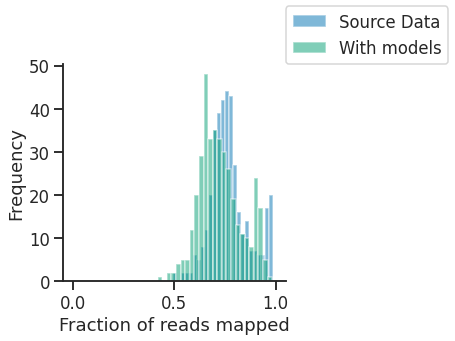

In [11]:
cdiff_rel=0.1
#df=genus['Unclassified']/genus.sum(axis=1)
#idx=df[df<.3].index.values
temp = relabund.groupby(axis=1,level=2).sum().copy()
temp=temp.drop('Unclassified',axis=1)
temp = temp.stack().reset_index()
temp['id']=[x+'-'+str(y) for x,y in zip(temp['level_0'].values,temp['level_1'].values)]
temp=temp.drop(['level_0','level_1'],axis=1)

temp.columns = ['genus','relative','id']
temp=temp[temp['relative']>=10**-3]
temp['reads'] = temp['relative']*depth
x1=temp.groupby(by='id')['relative'].sum().values
plt.figure(figsize=(4,4))
hist=plt.hist(x1,bins=25,label='Source Data',alpha=.5)
plt.xlabel('Sample Total Relative Abundance')
temp_model = merge(temp,agora,level='genus')
temp_genera = invade(temp_model,"",cdiff_rel,level='genus')
#temp_genera.to_csv('alm_%s_micom-%s-cdiff.csv'%('genus',cdiff_rel))
#temp_genera[temp_genera['genus']!='Clostridioides'].to_csv('alm_%s_micom-no-cdiff.csv'%('genus'))
x2=temp_genera[temp_genera['genus']!='Clostridioides'].groupby(by='samples')['relative'].sum().values
hist=plt.hist(x2,bins=25,label='With models',alpha=0.5,color='g')
plt.title('Level: %s'%'genus')
plt.legend(loc=(1,1))
plt.xlim(-.05,1.05)
plt.title('')
plt.ylabel('Frequency')
plt.xlabel('Fraction of reads mapped')
#plt.savefig('Model_abund_dist-ncbi.pdf',bbox_inches='tight')



/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


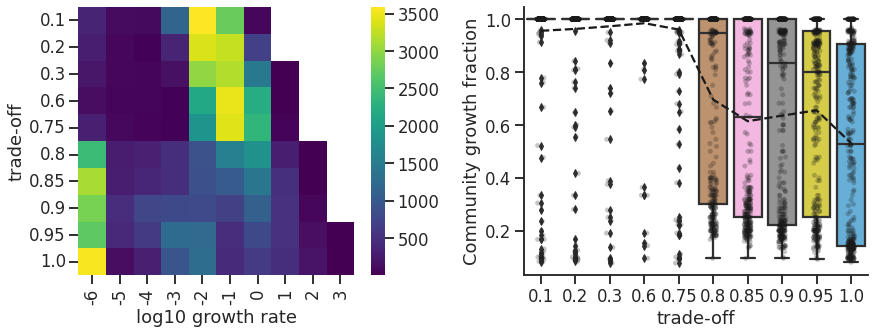

In [14]:
growth_rates=pd.read_pickle('../data/David_et_al_growth_rates_tradeoff_test.pkl').reset_index()
res=pd.DataFrame()
shannon=[]
richness=[]
total_rel=[]
for index,df in growth_rates.groupby(by=['sample','tradeoff']):
    abund=(df['abundance']).values
    total_rel.append(abund.sum())
    shannon.append(alpha.shannon(abund))
    richness.append(abund.shape[0])
    frac=len(df[df['growth_rate']>10**-6])/len(df)
    abund=df['abundance']*1000
    df = pd.DataFrame([[frac,index[1],index[0]]],columns=['growth_frac','tradeoff','sample'])
    res=res.append(df)
res['shannon']=shannon
res['richness']=richness
res['relabund']=total_rel
df=growth_rates[['growth_rate','tradeoff']]
df['loggrowth']=np.log10(df['growth_rate'].values)
df['bins']=pd.cut(df['loggrowth'],bins=[-50,-6,-5,-4,-3,-2,-1,0,1,2,3,10],labels=False)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12.5,5))
counts=df.groupby(by=['tradeoff','bins']).count()['loggrowth']
counts=counts.unstack()
g=sns.heatmap(counts,cmap='viridis',ax=ax1)
g.set_xticklabels([-6,-5,-4,-3,-2,-1,0,1,2,3])
g.set_xlabel('log10(growth rate)')


mean=res.groupby(by='tradeoff').mean()
sns.boxplot(x='tradeoff',y='growth_frac',data=res,ax=ax2)
sns.stripplot(x='tradeoff',y='growth_frac',data=res,alpha=0.25,ax=ax2,color='k')
ax2.plot(range(len(mean.index)),mean['growth_frac'].values.ravel(),'k--')
ax2.set_ylabel('Community growth fraction')
ax2.set_xlabel('trade-off')
ax1.set_ylabel('trade-off')
ax1.set_xlabel('log10 growth rate')
plt.tight_layout()
#plt.savefig('alm-tradeoff-vs-growthrate-ncbi.pdf',bbox_inches='tight')

Text(0, 0.5, 'Growth fraction')

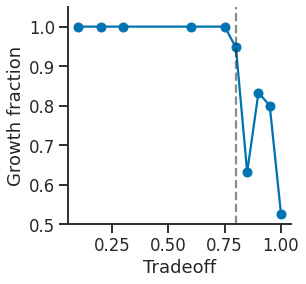

In [17]:
plt.figure(figsize=(4,4))
mean=res.groupby(by='tradeoff').median()
std=res.groupby(by='tradeoff').std()
#plt.fill_between(mean.index,mean.growth_frac-std.growth_frac,mean.growth_frac+std.growth_frac,alpha=0.25)
plt.plot(mean.index,mean.growth_frac,marker='o')

plt.plot((.8,.8),(.5,1.3),'k--',alpha=0.5)
plt.ylim(.5,1.05)
plt.xlabel('Tradeoff')
plt.ylabel('Growth fraction')
#plt.savefig('Tradeoff-growthfrac.pdf',bbox_inches='tight')

In [30]:
cdiff_counts=pd.read_csv('../data/David_et_al_cdiff_percent_alm.csv')
cdiff_counts

,Subject_ID,Day,total_reads,Cdiff_read_count,%C. difficile
0,A,0,43490,5,0.000115
1,A,1,67717,0,0.000000
2,A,4,68743,0,0.000000
3,A,5,105813,0,0.000000
4,A,6,136958,0,0.000000
...,...,...,...,...,...
445,B,212,83418,5,0.000060
446,B,213,67361,0,0.000000
447,B,214,83207,1,0.000012
448,B,215,122097,2,0.000016


In [79]:
growth_rates=pd.read_csv('../data/David_et_al__growth_rates_cdiff-01-tradeoff-test.csv')
growth_rates['donor']=np.nan
growth_rates['time']=np.nan
growth_rates.loc[:,['donor','time']]=[x.split('-') for x in growth_rates['sample']]
growth_rates['time']=growth_rates['time'].astype(int)
growth_rates=growth_rates.drop('sample',axis=1)
cdiff_growth=growth_rates[(growth_rates.compartments=='Clostridioides')]
cdiff_growth.abundance=cdiff_growth.abundance.round(3)
cdiff_growth

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,compartments,growth_rate,abundance,tradeoff,donor,time
2,Clostridioides,2.290545e-01,0.1,0.2,DonorA,107
17,Clostridioides,1.928375e-01,0.1,0.4,DonorA,107
32,Clostridioides,2.045064e-01,0.1,0.3,DonorA,107
47,Clostridioides,1.145112e-01,0.1,0.1,DonorA,107
62,Clostridioides,6.497654e-10,0.1,1.0,DonorA,107
...,...,...,...,...,...,...
75515,Clostridioides,2.053119e-10,0.1,0.5,DonorB,96
75531,Clostridioides,1.046215e-10,0.1,0.9,DonorB,96
75548,Clostridioides,5.813320e-10,0.1,0.8,DonorB,97
75565,Clostridioides,1.489333e-03,0.1,1.0,DonorB,97


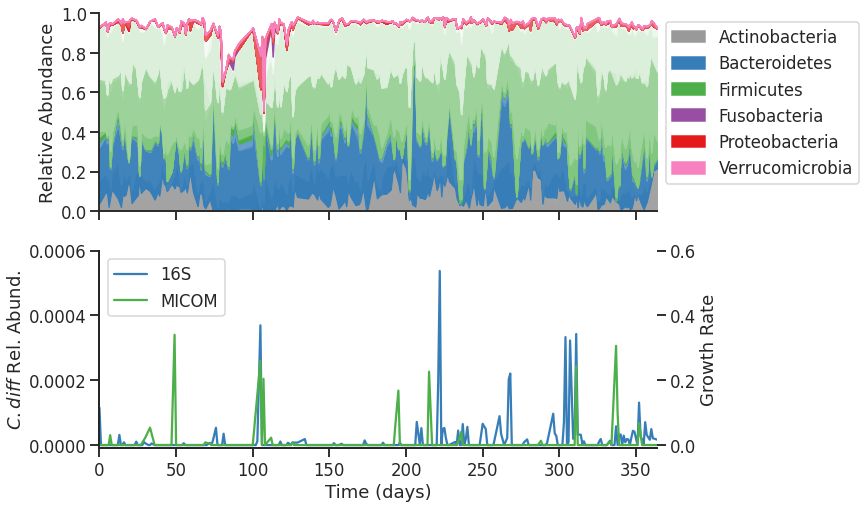

<Figure size 432x288 with 0 Axes>

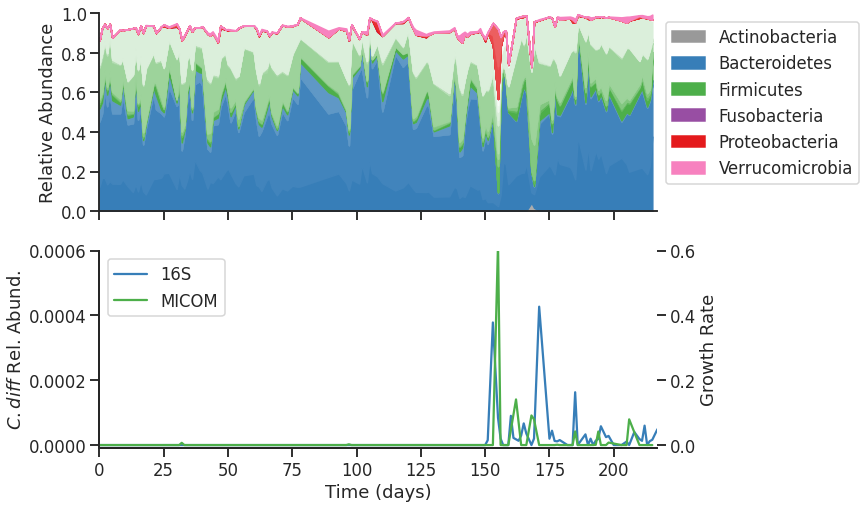

<Figure size 432x288 with 0 Axes>

In [80]:
def tint(rgb,alpha=1):
    rgb=np.array(rgb)*255
    rgb=rgb + (255 - rgb) * alpha
    return tuple(rgb/255)

relfam=relabund.groupby(level=[0,1],axis=1).sum()
#cols=relfam.columns.drop('Unclassified',level=0)
#relfam=relfam[cols]
#cols=relfam.columns.drop('Unclassified',level=1)
#relfam=relfam[cols]
for patient in relfam.index.levels[0]:
    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,8),sharex=True)
    idx=cdiff_counts[cdiff_counts.Subject_ID==patient[-1]].Day.values
    data=relfam.loc[patient]
    data=data.reindex(idx).dropna()
    bottom =np.zeros(len(data))
    x=data.index
    i=0
    colors=sns.color_palette('Set1')
    colors[4]=colors[0]
    colors[0]=colors[-1]
    colors[5]=colors[-2]
    for phy in pd.unique([x[0] for x in data.columns.values]):
        color=colors[i]
        df=data[phy]
        j=0
        for fam in df.columns:
            c=tint(color,alpha=j)
            y=df[fam]
            if j ==0:
                ax1.fill_between(x,bottom,bottom+y,color=c,label=phy)
            else:
                ax1.fill_between(x,bottom,bottom+y,color=c)
            bottom+=y
            j+=.05
        i+=1
    line1,=ax2.plot(cdiff_counts[cdiff_counts.Subject_ID==patient[-1]]['Day'],(cdiff_counts[cdiff_counts.Subject_ID==patient[-1]]['%C. difficile']).values,color=colors[1])
    
    df=cdiff_growth[(cdiff_growth.donor==patient)&(cdiff_growth.tradeoff==0.3)&(cdiff_growth.abundance==0.1)].sort_values(by='time')
    df.index=df.time
    df=df.reindex(idx).dropna()
    ax3=ax2.twinx()
    line2,=ax3.plot(df['time'],df['growth_rate'],color=colors[2])
    ax1.legend(bbox_to_anchor=(1,1),loc=2)
    ax2.set_xlabel('Time (days)')
    ax1.set_ylabel('Relative Abundance')
    ax2.set_ylabel('$C. diff$ Rel. Abund.')
    #ax1.set_title(patient)
    ax1.set_xlim(0,idx[-1])
    ax1.set_ylim(0,1)
    ax2.set_ylim(-0.00001,0.0006)
    ax3.set_ylim(-.01,0.6)
    ax3.set_ylabel('Growth Rate')
    ax3.legend([line1,line2],['16S','MICOM'],loc=2)
    #plt.savefig('%s-RelAbund-ncbi.png'%patient,bbox_inches='tight',dpi=500)
    #plt.savefig('%s-RelAbund-ncbi.pdf'%patient,bbox_inches='tight')
    plt.show()
    plt.clf()

In [81]:
growth_rates=pd.read_pickle('../data/David_et_al_growth_rates_tradeoff_cdiff_titr.pkl').reset_index()
growth_rates['donor']=np.nan
growth_rates['time']=np.nan
growth_rates.loc[:,['donor','time']]=[x.split('_')[1].split('-') for x in growth_rates['sample']]
growth_rates['time']=growth_rates['time'].astype(int)
growth_rates=growth_rates.drop('sample',axis=1)
cdiff_growth=growth_rates[(growth_rates.compartments=='Clostridioides')]
cdiff_growth.abundance=cdiff_growth.abundance.round(3)
cdiff_growth

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,compartments,growth_rate,abundance,tradeoff,donor,time
3,Clostridioides,1.664908e-03,0.001,0.75,DonorA,107
21,Clostridioides,1.507202e-02,0.010,0.70,DonorA,107
39,Clostridioides,1.698373e-02,0.010,0.80,DonorA,107
57,Clostridioides,1.690585e-01,0.100,0.70,DonorA,107
75,Clostridioides,1.811571e-01,0.100,0.75,DonorA,107
...,...,...,...,...,...,...
76362,Clostridioides,2.158288e-02,0.010,0.75,DonorB,97
76386,Clostridioides,2.343382e-03,0.001,0.75,DonorB,97
76410,Clostridioides,2.207414e-10,0.100,0.80,DonorB,97
76434,Clostridioides,1.077480e-10,0.010,0.80,DonorB,97


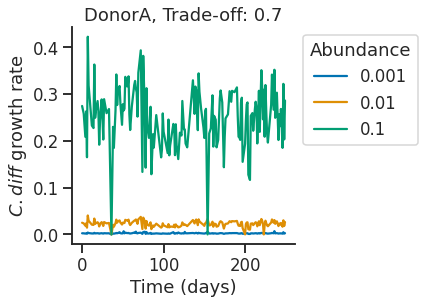

<Figure size 432x288 with 0 Axes>

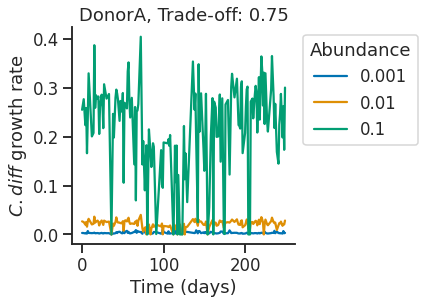

<Figure size 432x288 with 0 Axes>

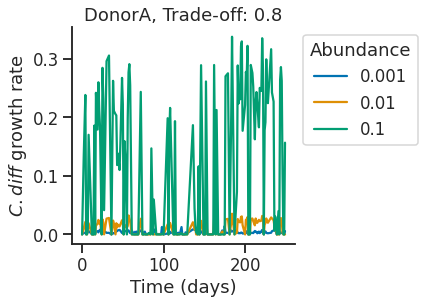

<Figure size 432x288 with 0 Axes>

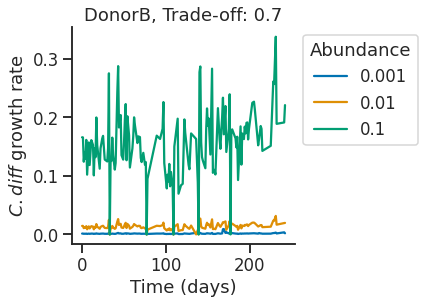

<Figure size 432x288 with 0 Axes>

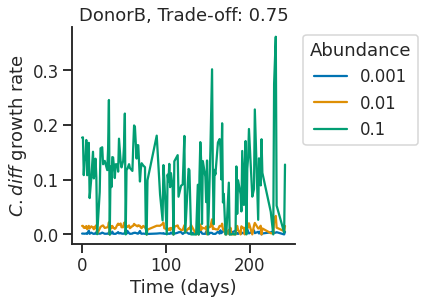

<Figure size 432x288 with 0 Axes>

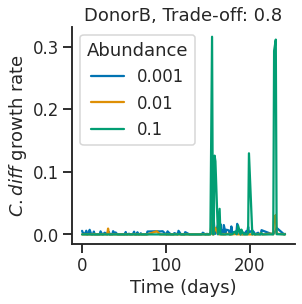

In [77]:
tradeoff=0
i=0
for idx,df in cdiff_growth.groupby(by=['donor','tradeoff','abundance']):
    df=df.sort_values(by='time')
    df=df[df['time']<250] 
    if idx[1] != tradeoff:
        if i != 0:
            plt.legend(bbox_to_anchor=(1,1),title='Abundance')
            #plt.savefig('Cdiff-%s-Trade-off-%s2.png'%(idx[0],tradeoff),dpi=500,bbox_inches='tight')
            plt.show()
            plt.clf()
        plt.figure(figsize=(4,4))
        plt.xlabel('Time (days)')
        plt.ylabel('$C. diff$ growth rate')
        tradeoff=idx[1]
        plt.title('%s, Trade-off: %s'%(idx[0],tradeoff))
        i+=1
    plt.plot(df['time'],df.growth_rate,label=idx[2])
    #plt.ylim(0,0.5)
    plt.legend(title='Abundance')
    #plt.show()
    #plt.clf()
#plt.savefig('Cdiff-%s-Trade-off-%s2.pdf'%(idx[0],tradeoff),bbox_inches='tight')